In [1]:
from music21 import *
from keras.utils import np_utils
import pandas as pd
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import sys

Using TensorFlow backend.


In [2]:
data_fn = 'Allwood_Richard_-_Claro_Pascali_Gaudio.mid'

In [3]:
midi = converter.parse(data_fn)

In [4]:
part1 = midi[1]

In [5]:
melodia = part1.getElementsByClass(note.Note)

In [6]:
notas = melodia.getElementsByClass(note.Note)

In [7]:
raw_text = []
for nota in notas:
    raw_text.append((str(nota.midi),str(nota.duration.quarterLength)))

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: Music21DeprecationWarning: Note._getMidi was deprecated on May 2014 and will disappear at or after May 2016. use pitch.midi instead
  app.launch_new_instance()


In [8]:
raw_text[:10]

[('65', '1.0'),
 ('67', '4/3'),
 ('65', '1/3'),
 ('65', '1.0'),
 ('64', '0.75'),
 ('62', '0.75'),
 ('62', '4/3'),
 ('65', '1/3'),
 ('64', '0.75'),
 ('65', '1.0')]

In [9]:
# create mapping of unique chars to integers
chars = sorted(list(set(raw_text))) #pega os caracteres utilizados no texto
char_to_int = dict((c, i) for i, c in enumerate(chars)) #mapeia cada caracter por um índice

In [10]:
n_chars = len(raw_text) # número total de caracteres no texto
n_vocab = len(chars) #numero de caracteres sem repetição
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  261
Total Vocab:  58


In [50]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 10 #tamanho da sequencia
dataX = [] 
dataY = []
for i in range(0, n_chars - seq_length, 1): #de zero até o a quantidade caracteres menos o tamanho da sequencia
	seq_in = raw_text[i:i + seq_length]     #pega uma janela do texto
	seq_out = raw_text[i + seq_length]      #uma posição depois da janela
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns) #qtde de janelas

Total Patterns:  251


In [51]:
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1)) 

In [52]:
# normalize
X = X / float(n_vocab)

In [53]:
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [54]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 58)                14906     
Total params: 279,098.0
Trainable params: 279,098.0
Non-trainable params: 0.0
_________________________________________________________________


In [56]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [57]:
model.fit(X, y, epochs=200, batch_size=16, callbacks=callbacks_list)

Epoch 1/200
251/251 [==============================] - 1s - loss: 3.9661     
Epoch 2/200
251/251 [==============================] - 0s - loss: 3.6002     
Epoch 3/200
251/251 [==============================] - 0s - loss: 3.5752     
Epoch 4/200
251/251 [==============================] - 0s - loss: 3.5165     
Epoch 5/200
251/251 [==============================] - 0s - loss: 3.5275     
Epoch 6/200
251/251 [==============================] - 0s - loss: 3.5368     
Epoch 7/200
251/251 [==============================] - 0s - loss: 3.5254     
Epoch 8/200
251/251 [==============================] - 0s - loss: 3.5032     
Epoch 9/200
251/251 [==============================] - 0s - loss: 3.4942     
Epoch 10/200
251/251 [==============================] - 0s - loss: 3.4899     
Epoch 11/200
251/251 [==============================] - 0s - loss: 3.4766     
Epoch 12/200
251/251 [==============================] - 0s - loss: 3.4453     
Epoch 13/200
251/251 [==============================] - 0s - 

In [58]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
# load the network weights
filename = "weights-improvement-198-0.3725.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [59]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [60]:
start = numpy.random.randint(0, len(dataX)-1)

In [61]:
pattern = dataX[start]

In [62]:
for value in pattern[:10]:
    print(int_to_char[value])

('62', '1.0')
('67', '0.75')
('65', '0.5')
('63', '0.5')
('62', '0.5')
('60', '0.5')
('58', '0.75')
('62', '0.75')
('65', '4/3')
('63', '0.5')


In [63]:
x = numpy.reshape(pattern, (1, len(pattern), 1))

In [65]:
# generate characters
for i in range(10):
    x = numpy.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    print(result)
    #sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print("\nDone.")

('65', '0.25')
('64', '0.25')
('64', '0.25')
('67', '0.5')
('62', '1.0')
('62', '1.0')
('62', '0.25')
('62', '0.25')
('60', '0.5')
('58', '0.75')

Done.


In [155]:
from fractions import Fraction

In [175]:
# generate characters
stream1 = stream.Stream()
for i in range(20):
    x = numpy.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]    
    
    #nota.duration.quarterLength = int(result[1])
    x = int(result[0])          
    y = Fraction(result[1])  
    print(result,x,type(x))
    n = note.Note()
    n.pitch.midi = x 
    n.duration.quarterLength = y
    stream1.append(n)
    
    #sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]   
print("\nDone.")

('64', '0.25') 64 <class 'int'>
('67', '0.5') 67 <class 'int'>
('69', '0.75') 69 <class 'int'>
('67', '0.5') 67 <class 'int'>
('63', '0.75') 63 <class 'int'>
('69', '0.5') 69 <class 'int'>
('64', '0.25') 64 <class 'int'>
('65', '0.75') 65 <class 'int'>
('69', '0.75') 69 <class 'int'>
('65', '0.25') 65 <class 'int'>
('62', '0.25') 62 <class 'int'>
('62', '0.25') 62 <class 'int'>
('67', '0.25') 67 <class 'int'>
('65', '0.25') 65 <class 'int'>
('64', '0.25') 64 <class 'int'>
('60', '0.25') 60 <class 'int'>
('69', '0.5') 69 <class 'int'>
('62', '0.5') 62 <class 'int'>
('62', '1.0') 62 <class 'int'>
('62', '4/3') 62 <class 'int'>

Done.


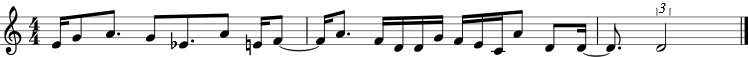

In [176]:
stream1.show()    

In [140]:
##gerar uma escala

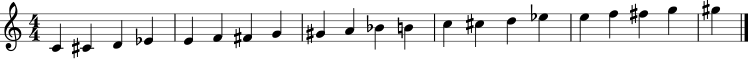

In [141]:
stream2 = stream.Stream()
for x in range(60, 81):
    n = note.Note()
    n.pitch.midi = x
    stream2.append(n)
stream2.show()